In [1]:
# 1. Import Libraries and Setup
import pandas as pd
import requests
import os
import time
import glob
import urllib.request
import xml.etree.ElementTree as ET
import tarfile
import shutil
import re
import matplotlib.pyplot as plt
from datetime import datetime

# Define output folders
pdf_output_folder = 'Positive_PMC_PDFs'
supp_output_folder = 'Positive_PMC_Supplementary'
tsv_output_folder = 'Positive_PMC_TSV_Files'

os.makedirs(pdf_output_folder, exist_ok=True)
os.makedirs(supp_output_folder, exist_ok=True)
os.makedirs(tsv_output_folder, exist_ok=True)

print("Directories created/verified:")
print(f"- {pdf_output_folder}")
print(f"- {supp_output_folder}")
print(f"- {tsv_output_folder}")

Directories created/verified:
- Positive_PMC_PDFs
- Positive_PMC_Supplementary
- Positive_PMC_TSV_Files


In [2]:
# 2. Load Input Data
# Load the input CSV files
positive_entries_file = 'positive_entries.csv'
top_pos_file = 'top_pos.csv'

print(f"Loading {positive_entries_file}...")
df_positive = pd.read_csv(positive_entries_file)
print(f"Loaded {len(df_positive)} rows.")

print(f"Loading {top_pos_file}...")
df_top = pd.read_csv(top_pos_file)
print(f"Loaded {len(df_top)} rows.")

# Combine the dataframes
df_combined = pd.concat([df_positive, df_top], ignore_index=True)

# Remove duplicates based on PMCID
df_combined = df_combined.drop_duplicates(subset=['PMCID'])

# Filter for rows with valid PMCIDs
df_combined = df_combined[df_combined['PMCID'].notna()]

# Map columns to match the expected names in the adapted pipeline
df_combined['mapped_pmcid'] = df_combined['PMCID']
df_combined['mapped_pmid'] = df_combined['PMID']
df_combined['publication_doi'] = df_combined['DOI']
df_combined['article_title'] = df_combined['Title']
df_combined['article_abstract'] = df_combined['Abstract']

# Create a working TSV file to track progress
output_tsv_file_name = os.path.join(tsv_output_folder, 'positive_entries_status.tsv')
df_combined.to_csv(output_tsv_file_name, sep='\t', index=False)

print(f"\nCombined unique entries with PMCID: {len(df_combined)}")
print(f"Working TSV saved to: {output_tsv_file_name}")

Loading positive_entries.csv...
Loaded 952 rows.
Loading top_pos.csv...
Loaded 460 rows.

Combined unique entries with PMCID: 995
Working TSV saved to: Positive_PMC_TSV_Files/positive_entries_status.tsv

Combined unique entries with PMCID: 995
Working TSV saved to: Positive_PMC_TSV_Files/positive_entries_status.tsv


In [4]:
# 3. Download full text PDFs using PMCIDs from Europe PMC
# Note: Europe PMC does not directly provide PDFs through REST API - we need to use alternative methods

# Read in the working TSV
df = pd.read_csv(output_tsv_file_name, sep='\t')

# Extract PMCIDs from the DataFrame
pmcids = df['mapped_pmcid'].dropna().unique()

# Use the defined output folder
output_folder = pdf_output_folder

# Track which PMCIDs need downloading (skip already downloaded)
to_download_pmcid = []
for pmcid in pmcids:
    if os.path.exists(f'{output_folder}/{pmcid}_main.pdf'):
        print(f"PDF for PMCID {pmcid} already downloaded.")
    else:
        # print(f"PDF for PMCID {pmcid} not yet downloaded.") # Reduce verbosity
        to_download_pmcid.append(pmcid)

print(f"\nNeed to download {len(to_download_pmcid)} PDFs out of {len(pmcids)} total entries.\n")

# Function to download full text PDF
def download_pdfs(pmcids):
    """
    Download PDFs from Europe PMC. 
    Note: Direct PDF downloads are not always available through Europe PMC REST API.
    We'll try multiple approaches:
    1. Try to get PDF link from article metadata
    2. Download supplementary files if available
    3. Construct publisher URLs where possible
    """
    success_count = 0
    fail_count = 0
    
    for idx, pmcid in enumerate(pmcids, 1):
        print(f"[{idx}/{len(pmcids)}] Processing {pmcid}...")
        
        # Clean PMCID (remove 'PMC' prefix for some API calls)
        clean_pmcid = pmcid.replace('PMC', '') if pmcid.startswith('PMC') else pmcid
        
        # Try Method 1: Get article metadata to find PDF link
        try:
            metadata_url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=PMCID:{pmcid}&resultType=core&format=json"
            metadata_response = requests.get(metadata_url, timeout=30)
            
            if metadata_response.status_code == 200:
                metadata = metadata_response.json()
                
                if metadata.get('hitCount', 0) > 0:
                    result = metadata['resultList']['result'][0]
                    
                    # Try to get PDF link from fullTextUrlList
                    if 'fullTextUrlList' in result and result['fullTextUrlList']:
                        for url_info in result['fullTextUrlList']['fullTextUrl']:
                            if url_info.get('documentStyle') == 'pdf' or url_info.get('availabilityCode') == 'OA':
                                pdf_url = url_info.get('url')
                                
                                if pdf_url and '.pdf' in pdf_url.lower():
                                    # Try to download the PDF
                                    pdf_response = requests.get(pdf_url, timeout=30, allow_redirects=True)
                                    
                                    if pdf_response.status_code == 200 and pdf_response.headers.get('Content-Type', '').startswith('application/pdf'):
                                        output_file = os.path.join(output_folder, f"{pmcid}_main.pdf")
                                        with open(output_file, 'wb') as file:
                                            file.write(pdf_response.content)
                                        print(f"  ✓ Downloaded main PDF from publisher")
                                        success_count += 1
                                        break
                    
                    # If no PDF found yet, try PMC OA service
                    if not os.path.exists(f'{output_folder}/{pmcid}_main.pdf'):
                        # Try Europe PMC OA PDF service (different endpoint)
                        pmc_oa_url = f"https://europepmc.org/articles/{pmcid}?pdf=render"
                        pmc_response = requests.get(pmc_oa_url, timeout=30, allow_redirects=True)
                        
                        if pmc_response.status_code == 200 and len(pmc_response.content) > 1000:
                            # Check if it's actually a PDF
                            if pmc_response.content[:4] == b'%PDF':
                                output_file = os.path.join(output_folder, f"{pmcid}_main.pdf")
                                with open(output_file, 'wb') as file:
                                    file.write(pmc_response.content)
                                print(f"  ✓ Downloaded main PDF from PMC OA service")
                                success_count += 1
                            else:
                                print(f"  ✗ Could not retrieve PDF (not openly available)")
                                fail_count += 1
                        else:
                            print(f"  ✗ Could not retrieve PDF (status: {pmc_response.status_code})")
                            fail_count += 1
        
        except Exception as e:
            print(f"  ✗ Error downloading main PDF: {str(e)}")
            fail_count += 1
        
        # Rate limiting - be respectful to the API
        time.sleep(0.5)
    
    print(f"\n{'='*60}")
    print(f"DOWNLOAD SUMMARY")
    print(f"{'='*60}")
    print(f"Main PDFs successfully downloaded: {success_count}")
    print(f"Main PDFs failed/not available: {fail_count}")
    print(f"{'='*60}\n")

# Download PDFs for each PMCID that hasn't been downloaded yet
if to_download_pmcid:
    download_pdfs(to_download_pmcid)
else:
    print("All PDFs already downloaded. Skipping download step.")

# Update the TSV with download status
print("Updating TSV with PDF download status...")
pdf_downloadable = []

for pmcid in df['mapped_pmcid']:
    if pd.notna(pmcid) and os.path.exists(f'{output_folder}/{pmcid}_main.pdf'):
        pdf_downloadable.append('yes')
    else:
        pdf_downloadable.append('no')

# Add the new column of download status to the DataFrame and save
df['pdf_downloadable'] = pdf_downloadable
df.to_csv(output_tsv_file_name, sep='\t', index=False)
print(f"✓ Updated TSV with PDF download status saved to '{output_tsv_file_name}'")

PDF for PMCID PMC8962827 already downloaded.
PDF for PMCID PMC6630050 already downloaded.
PDF for PMCID PMC10581726 already downloaded.
PDF for PMCID PMC9294765 already downloaded.
PDF for PMCID PMC11043263 already downloaded.
PDF for PMCID PMC11791183 already downloaded.
PDF for PMCID PMC11922705 already downloaded.
PDF for PMCID PMC11666702 already downloaded.
PDF for PMCID PMC7902477 already downloaded.
PDF for PMCID PMC9438026 already downloaded.
PDF for PMCID PMC8042299 already downloaded.
PDF for PMCID PMC8861232 already downloaded.
PDF for PMCID PMC10492341 already downloaded.
PDF for PMCID PMC10837709 already downloaded.
PDF for PMCID PMC6897314 already downloaded.
PDF for PMCID PMC10283114 already downloaded.
PDF for PMCID PMC9953018 already downloaded.
PDF for PMCID PMC8266002 already downloaded.
PDF for PMCID PMC10601590 already downloaded.
PDF for PMCID PMC10473108 already downloaded.
PDF for PMCID PMC10043063 already downloaded.
PDF for PMCID PMC5486409 already downloaded.

In [6]:
# 4. Download supplementary files using NCBI OA API and organize by PMCID
 
# Read in the working TSV
df = pd.read_csv(output_tsv_file_name, sep='\t')

# Extract PMCIDs from the DataFrame
if 'mapped_pmcid' in df.columns:
    pmcids = df['mapped_pmcid'].dropna().unique()
    print(f"Found {len(pmcids)} PMCIDs to process for supplementary files")
else:
    print("Error: 'mapped_pmcid' column not found in TSV.")
    pmcids = []

# Define the output folder for supplementary files
# supp_output_folder is already defined in Cell 1

# Human-readable file extensions to keep - ONLY PDF as per request
KEEP_EXTENSIONS = {'.pdf'}

# Track which PMCIDs need downloading
to_download_pmcids = []
already_downloaded = 0

for pmcid in pmcids:
    pmcid_folder = os.path.join(supp_output_folder, pmcid)
    # Check if folder exists and has files
    if os.path.exists(pmcid_folder):
        files = [f for f in os.listdir(pmcid_folder) if os.path.isfile(os.path.join(pmcid_folder, f))]
        if files:
            # print(f"Supplementary files for {pmcid} already downloaded ({len(files)} files).")
            already_downloaded += 1
        else:
            # Folder exists but empty - re-download
            to_download_pmcids.append(pmcid)
    else:
        to_download_pmcids.append(pmcid)

print(f"\nAlready downloaded: {already_downloaded} PMCIDs")
print(f"Need to download: {len(to_download_pmcids)} PMCIDs\n")

# Function to download and extract supplementary files from NCBI OA
def download_supplementary_files(pmcids):
    """
    Download supplementary files from NCBI PMC Open Access FTP.
    Uses NCBI OA API to find FTP location for each PMCID.
    Extracts only PDF files.
    """
    success_count = 0
    fail_count = 0
    total_files_extracted = 0
    
    for idx, pmcid in enumerate(pmcids, 1):
        print(f"[{idx}/{len(pmcids)}] Processing {pmcid}...")
        
        try:
            # Create folder for this PMCID
            pmcid_folder = os.path.join(supp_output_folder, pmcid)
            os.makedirs(pmcid_folder, exist_ok=True)
            
            # Use NCBI OA API to find the exact FTP path
            api_url = f"https://www.ncbi.nlm.nih.gov/pmc/utils/oa/oa.fcgi?id={pmcid}"
            
            with urllib.request.urlopen(api_url, timeout=30) as response:
                xml_data = response.read()
            
            # Parse the XML to find the FTP link (format="tgz" contains all files)
            root = ET.fromstring(xml_data)
            link_element = root.find(".//link[@format='tgz']")
            
            if link_element is not None:
                ftp_url = link_element.get("href")
                tar_filename = os.path.join(pmcid_folder, f"{pmcid}.tar.gz")
                
                print(f"  Found FTP location: {ftp_url}")
                print(f"  Downloading...")
                
                # Download the .tar.gz file
                urllib.request.urlretrieve(ftp_url, tar_filename)
                
                print(f"  Extracting files...")
                
                # Extract and filter files
                files_kept = 0
                with tarfile.open(tar_filename, "r:gz") as tar:
                    for member in tar.getmembers():
                        if member.isfile():
                            # Get file extension
                            _, ext = os.path.splitext(member.name.lower())
                            
                            # Keep only human-readable files
                            if ext in KEEP_EXTENSIONS:
                                # Extract with sanitized filename (remove directory structure)
                                member.name = os.path.basename(member.name)
                                tar.extract(member, path=pmcid_folder)
                                files_kept += 1
                                print(f"    ✓ Extracted: {member.name}")
                            else:
                                # print(f"    ✗ Skipped (not PDF): {member.name}")
                                pass
                
                # Remove the .tar.gz file after extraction
                os.remove(tar_filename)
                
                if files_kept > 0:
                    print(f"  ✓ Successfully extracted {files_kept} PDF file(s)")
                    success_count += 1
                    total_files_extracted += files_kept
                else:
                    print(f"  ⚠ No PDF files found in package")
                    # Remove empty folder
                    try:
                        os.rmdir(pmcid_folder)
                    except:
                        pass
                    fail_count += 1
                    
            else:
                print(f"  ✗ No open access FTP link found (may be under copyright)")
                # Remove empty folder
                try:
                    os.rmdir(pmcid_folder)
                except:
                    pass
                fail_count += 1
                
        except urllib.error.HTTPError as e:
            print(f"  ✗ HTTP Error: {e.code} - {e.reason}")
            fail_count += 1
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            fail_count += 1
        
        # Rate limiting - be respectful to the API
        time.sleep(0.5)
    
    print(f"\n{'='*60}")
    print(f"SUPPLEMENTARY FILES DOWNLOAD SUMMARY")
    print(f"{'='*60}")
    print(f"PMCIDs with supplementary files downloaded: {success_count}")
    print(f"PMCIDs without supplementary files/failed: {fail_count}")
    print(f"Total PDF files extracted: {total_files_extracted}")
    print(f"{'='*60}\n")

# Download supplementary files only for those that need it
if to_download_pmcids:
    download_supplementary_files(to_download_pmcids)
else:
    print("All supplementary files already downloaded. Skipping download step.\n")

# Update TSV with supplementary files information
print("Updating TSV with supplementary files information...")

supp_download_status = []
supp_file_count = []
supp_file_list = []

for pmcid in df['mapped_pmcid']:
    if pd.notna(pmcid):
        pmcid_folder = os.path.join(supp_output_folder, pmcid)
        
        if os.path.exists(pmcid_folder):
            # Count files in the folder
            files = [f for f in os.listdir(pmcid_folder) if os.path.isfile(os.path.join(pmcid_folder, f))]
            count = len(files)
            
            if count > 0:
                supp_download_status.append('yes')
                supp_file_count.append(count)
                supp_file_list.append('; '.join(files))
            else:
                supp_download_status.append('no')
                supp_file_count.append(0)
                supp_file_list.append(None)
        else:
            supp_download_status.append('no')
            supp_file_count.append(0)
            supp_file_list.append(None)
    else:
        supp_download_status.append('no')
        supp_file_count.append(0)
        supp_file_list.append(None)

# Add columns to DataFrame
df['supplementary_downloadable'] = supp_download_status
df['supplementary_file_count'] = supp_file_count
df['supplementary_file_list'] = supp_file_list

# Save updated TSV
df.to_csv(output_tsv_file_name, sep='\t', index=False)
print(f"✓ Updated TSV saved to '{output_tsv_file_name}'")

# Print statistics
total_supp_files = sum(supp_file_count)
entries_with_supp = sum(1 for status in supp_download_status if status == 'yes')

print(f"\nSupplementary Files Statistics:")
print(f"  Total supplementary files: {total_supp_files}")
print(f"  Entries with supplementary files: {entries_with_supp}/{len(df)}")
if len(df) > 0:
    print(f"  Success rate: {entries_with_supp/len(df)*100:.1f}%")

Found 995 PMCIDs to process for supplementary files

Already downloaded: 566 PMCIDs
Need to download: 429 PMCIDs

[1/429] Processing PMC10581726...
  ✗ No open access FTP link found (may be under copyright)
  ✗ No open access FTP link found (may be under copyright)
[2/429] Processing PMC7902477...
[2/429] Processing PMC7902477...
  ✗ No open access FTP link found (may be under copyright)
  ✗ No open access FTP link found (may be under copyright)
[3/429] Processing PMC6897314...
[3/429] Processing PMC6897314...
  ✗ No open access FTP link found (may be under copyright)
  ✗ No open access FTP link found (may be under copyright)
[4/429] Processing PMC10283114...
[4/429] Processing PMC10283114...
  ✗ No open access FTP link found (may be under copyright)
  ✗ No open access FTP link found (may be under copyright)
[5/429] Processing PMC10043063...
[5/429] Processing PMC10043063...
  ✗ No open access FTP link found (may be under copyright)
  ✗ No open access FTP link found (may be under copyr

/tmp/ipykernel_29955/1504476800.py:94: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(member, path=pmcid_folder)


[193/429] Processing PMC8722819...
  ✗ No open access FTP link found (may be under copyright)
  ✗ No open access FTP link found (may be under copyright)
[194/429] Processing PMC11893473...
[194/429] Processing PMC11893473...
  Found FTP location: ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/8c/44/PMC11893473.tar.gz
  Downloading...
  Found FTP location: ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/8c/44/PMC11893473.tar.gz
  Downloading...
  Extracting files...
    ✓ Extracted: mmc1.pdf
    ✓ Extracted: main.pdf
  ✓ Successfully extracted 2 PDF file(s)
  Extracting files...
    ✓ Extracted: mmc1.pdf
    ✓ Extracted: main.pdf
  ✓ Successfully extracted 2 PDF file(s)
[195/429] Processing PMC9196053...
[195/429] Processing PMC9196053...
  Found FTP location: ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/47/fe/PMC9196053.tar.gz
  Downloading...
  Found FTP location: ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/47/fe/PMC9196053.tar.gz
  Downloading...
  Extracting files...
    ✓ Extracted

In [7]:
# 5. Clean and organize PDF files
# - Integrates main PDFs into supplementary folders with smart replacement
# - Cleans irrelevant files based on keyword heuristics

print("="*60)
print("CLEANING AND ORGANIZATION")
print("="*60)

pdf_source_folder = pdf_output_folder
supp_root_folder = supp_output_folder

# Statistics tracking
stats = {
    'folders_created': 0,
    'main_pdfs_moved': 0,
    'replacements_exact': 0,
    'replacements_diff_size': 0,
    'irrelevant_removed': 0,
    'files_kept': 0,
    'prefixes_cleaned': 0
}

# Keywords for filtering supplementary files
KEEP_KEYWORDS = [r's\d+', r'sup', r'supp', r'supplementary', r'table', r'figure', r'data', r'appendix']
REMOVE_KEYWORDS = [r'review', r'comment', r'response', r'revision', r'original', r'author', r'letter', r'correction']

def is_irrelevant(filename):
    """Check if file should be removed based on keywords."""
    name_lower = filename.lower()
    # If it matches remove keywords
    for kw in REMOVE_KEYWORDS:
        if re.search(kw, name_lower):
            return True, kw
    return False, None

# 0. Clean up existing 'potential_duplicate_' prefixes
if os.path.exists(supp_root_folder):
    print("\n0. Cleaning up 'potential_duplicate_' prefixes...")
    for root, dirs, files in os.walk(supp_root_folder):
        for file in files:
            if 'potential_duplicate_' in file:
                file_path = os.path.join(root, file)
                # Remove all occurrences of the prefix
                new_name = file.replace('potential_duplicate_', '')
                new_path = os.path.join(root, new_name)
                
                try:
                    if os.path.exists(new_path):
                        # If target exists, remove the prefixed file (it's likely a duplicate or unwanted version)
                        os.remove(file_path)
                        print(f"  ✓ Removed prefixed file (target exists): {file}")
                    else:
                        # Rename to clean name
                        os.rename(file_path, new_path)
                        print(f"  ✓ Renamed {file} -> {new_name}")
                    stats['prefixes_cleaned'] += 1
                except Exception as e:
                    print(f"  ✗ Error cleaning prefix for {file}: {e}")

# 1. Process Main PDFs
if os.path.exists(pdf_source_folder):
    print("\n1. Integrating Main PDFs...")
    for filename in os.listdir(pdf_source_folder):
        if filename.endswith('_main.pdf'):
            pmcid = filename.replace('_main.pdf', '')
            source_path = os.path.join(pdf_source_folder, filename)
            dest_folder = os.path.join(supp_root_folder, pmcid)
            dest_path = os.path.join(dest_folder, filename)
            
            # Create folder if it doesn't exist
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder, exist_ok=True)
                stats['folders_created'] += 1
            
            # Check for existing files in destination to see if we need to replace/merge
            # Exclude the target filename itself to avoid comparing/deleting the file we are about to write
            existing_files = [f for f in os.listdir(dest_folder) if f.endswith('.pdf') and f != filename]
            
            src_size = os.path.getsize(source_path)
            
            # 1. Check for exact size matches among ANY existing PDFs and remove them
            for existing_pdf in existing_files:
                existing_path = os.path.join(dest_folder, existing_pdf)
                try:
                    if os.path.getsize(existing_path) == src_size:
                        os.remove(existing_path)
                        stats['replacements_exact'] += 1
                        print(f"  ✓ Removed identical file {existing_pdf} (size match)")
                except Exception as e:
                    print(f"  ✗ Error checking/removing {existing_pdf}: {e}")
            
            # 2. Copy the main PDF (Overwrite if exists)
            try:
                shutil.copy2(source_path, dest_path)
                stats['main_pdfs_moved'] += 1
            except Exception as e:
                print(f"  ✗ Error copying main PDF: {e}")

# 2. Clean Irrelevant Files
if os.path.exists(supp_root_folder):
    print("\n2. Cleaning Irrelevant Files...")
    for root, dirs, files in os.walk(supp_root_folder):
        for file in files:
            # Skip the main PDFs we just organized
            if file.endswith('_main.pdf'):
                continue
                
            file_path = os.path.join(root, file)
            
            # Check for removal keywords
            should_remove, reason = is_irrelevant(file)
            
            if should_remove:
                try:
                    os.remove(file_path)
                    stats['irrelevant_removed'] += 1
                    print(f"  ✓ Removed (matched '{reason}'): {file}")
                except Exception as e:
                    print(f"  ✗ Error removing {file}: {e}")
            else:
                stats['files_kept'] += 1

print(f"\n{'='*60}")
print("CLEANING SUMMARY")
print(f"{'='*60}")
print(f"Prefixes cleaned: {stats['prefixes_cleaned']}")
print(f"New folders created for orphans: {stats['folders_created']}")
print(f"Main PDFs integrated: {stats['main_pdfs_moved']}")
print(f"Exact duplicate replacements: {stats['replacements_exact']}")
print(f"Irrelevant files removed: {stats['irrelevant_removed']}")
print(f"Supplementary files retained: {stats['files_kept']}")
print(f"{'='*60}\n")

CLEANING AND ORGANIZATION

0. Cleaning up 'potential_duplicate_' prefixes...

1. Integrating Main PDFs...
  ✓ Removed identical file 11734_2022_Article_649.pdf (size match)
  ✓ Removed identical file main.pdf (size match)
  ✓ Removed identical file EC-24-0169.pdf (size match)
  ✓ Removed identical file jf2c03339.pdf (size match)
  ✓ Removed identical file bax019.pdf (size match)
  ✓ Removed identical file 10-1055-s-0042-1750785.pdf (size match)
  ✓ Removed identical file bmjsem-2021-001242.pdf (size match)
  ✓ Removed identical file ABB2022-2188152.pdf (size match)
  ✓ Removed identical file cia-16-1723.pdf (size match)
  ✓ Removed identical file PHY2-12-e16182.pdf (size match)
  ✓ Removed identical file JOA-245-903.pdf (size match)
  ✓ Removed identical file ebm-249-10341.pdf (size match)
  ✓ Removed identical file 12195_2024_Article_821.pdf (size match)
  ✓ Removed identical file biol-2020-0055.pdf (size match)
  ✓ Removed identical file KONI_11_2028962.pdf (size match)
  ✓ Removed i

In [ ]:
# 5.5 Analyze PDF file sizes
# Calculate file sizes and flag large files (>50MB)

print("="*60)
print("ANALYZING PDF FILE SIZES")
print("="*60)

pdf_folder = pdf_output_folder
large_file_threshold_mb = 50
large_file_threshold_bytes = large_file_threshold_mb * 1024 * 1024

file_sizes = []
large_files = []

if os.path.exists(pdf_folder):
    # Iterate through all PDF files
    for filename in os.listdir(pdf_folder):
        if filename.endswith('.pdf'):
            file_path = os.path.join(pdf_folder, filename)
            try:
                size_bytes = os.path.getsize(file_path)
                size_mb = size_bytes / (1024 * 1024)
                
                file_sizes.append(size_mb)
                
                if size_bytes > large_file_threshold_bytes:
                    large_files.append({
                        'filename': filename,
                        'size_mb': size_mb
                    })
            except Exception as e:
                print(f"Error getting size for {filename}: {e}")

    # Calculate statistics
    if file_sizes:
        min_size = min(file_sizes)
        max_size = max(file_sizes)
        avg_size = sum(file_sizes) / len(file_sizes)
        total_size = sum(file_sizes)
        
        print(f"Total PDFs analyzed: {len(file_sizes)}")
        print(f"Total size: {total_size:.2f} MB")
        print(f"Average size: {avg_size:.2f} MB")
        print(f"Min size: {min_size:.2f} MB")
        print(f"Max size: {max_size:.2f} MB")
        
        print(f"\nLarge files (> {large_file_threshold_mb} MB): {len(large_files)}")
        if large_files:
            # Sort by size descending
            large_files.sort(key=lambda x: x['size_mb'], reverse=True)
            for f in large_files:
                print(f"  - {f['filename']}: {f['size_mb']:.2f} MB")
        else:
            print("  None found.")
            
        # Optional: Plot histogram of file sizes
        plt.figure(figsize=(10, 6))
        plt.hist(file_sizes, bins=50, color='skyblue', edgecolor='black')
        plt.title('Distribution of PDF File Sizes')
        plt.xlabel('Size (MB)')
        plt.ylabel('Count')
        plt.axvline(x=large_file_threshold_mb, color='r', linestyle='--', label=f'{large_file_threshold_mb} MB Threshold')
        plt.legend()
        plt.grid(axis='y', alpha=0.5)
        
        # Save plot
        size_plot_path = os.path.join(tsv_output_folder, 'PDF_Size_Distribution.png')
        plt.savefig(size_plot_path)
        print(f"\nSize distribution plot saved to: {size_plot_path}")
        plt.show()
        
    else:
        print("No PDF files found to analyze.")
else:
    print(f"PDF folder not found: {pdf_folder}")

print("\nBlock 5.5 complete.")

GENERATING COMPREHENSIVE METADATA REPORT

1. Analyzing Registry retrieval...
  Total Entries: 995
  Entries with DOI: 995
  Entries without DOI: 0

2. Analyzing PMCID availability...
  Entries processed: 995
  Entries with PMCID: 995 (100.0%)
  Entries with PMID only: 0

3. Analyzing full text PDF retrieval...
  PDFs successfully downloaded: 967 (97.2% of PMCIDs)
  PDFs not available: 28

4. Analyzing supplementary files retrieval...
  Entries with supplementary files: 737 (74.1% of PMCIDs)
  Total supplementary files downloaded: 1030
  Average files per entry (with supp): 1.40
  Entries with 1 file: 566
  Entries with 2-5 files: 166
  Entries with 6+ files: 5

5. Analyzing title/abstract availability...
  Complete title & abstract: 995 (100.0% of PMCIDs)
  Title only: 0
  Abstract only: 0
  Neither available: 0

6. Calculating overall pipeline success...
  Full data retrieval (PDF + Supp + Title/Abstract): 722 (72.6%)
  PDF + Title/Abstract (no supp required): 967 (97.2%)
  At least P

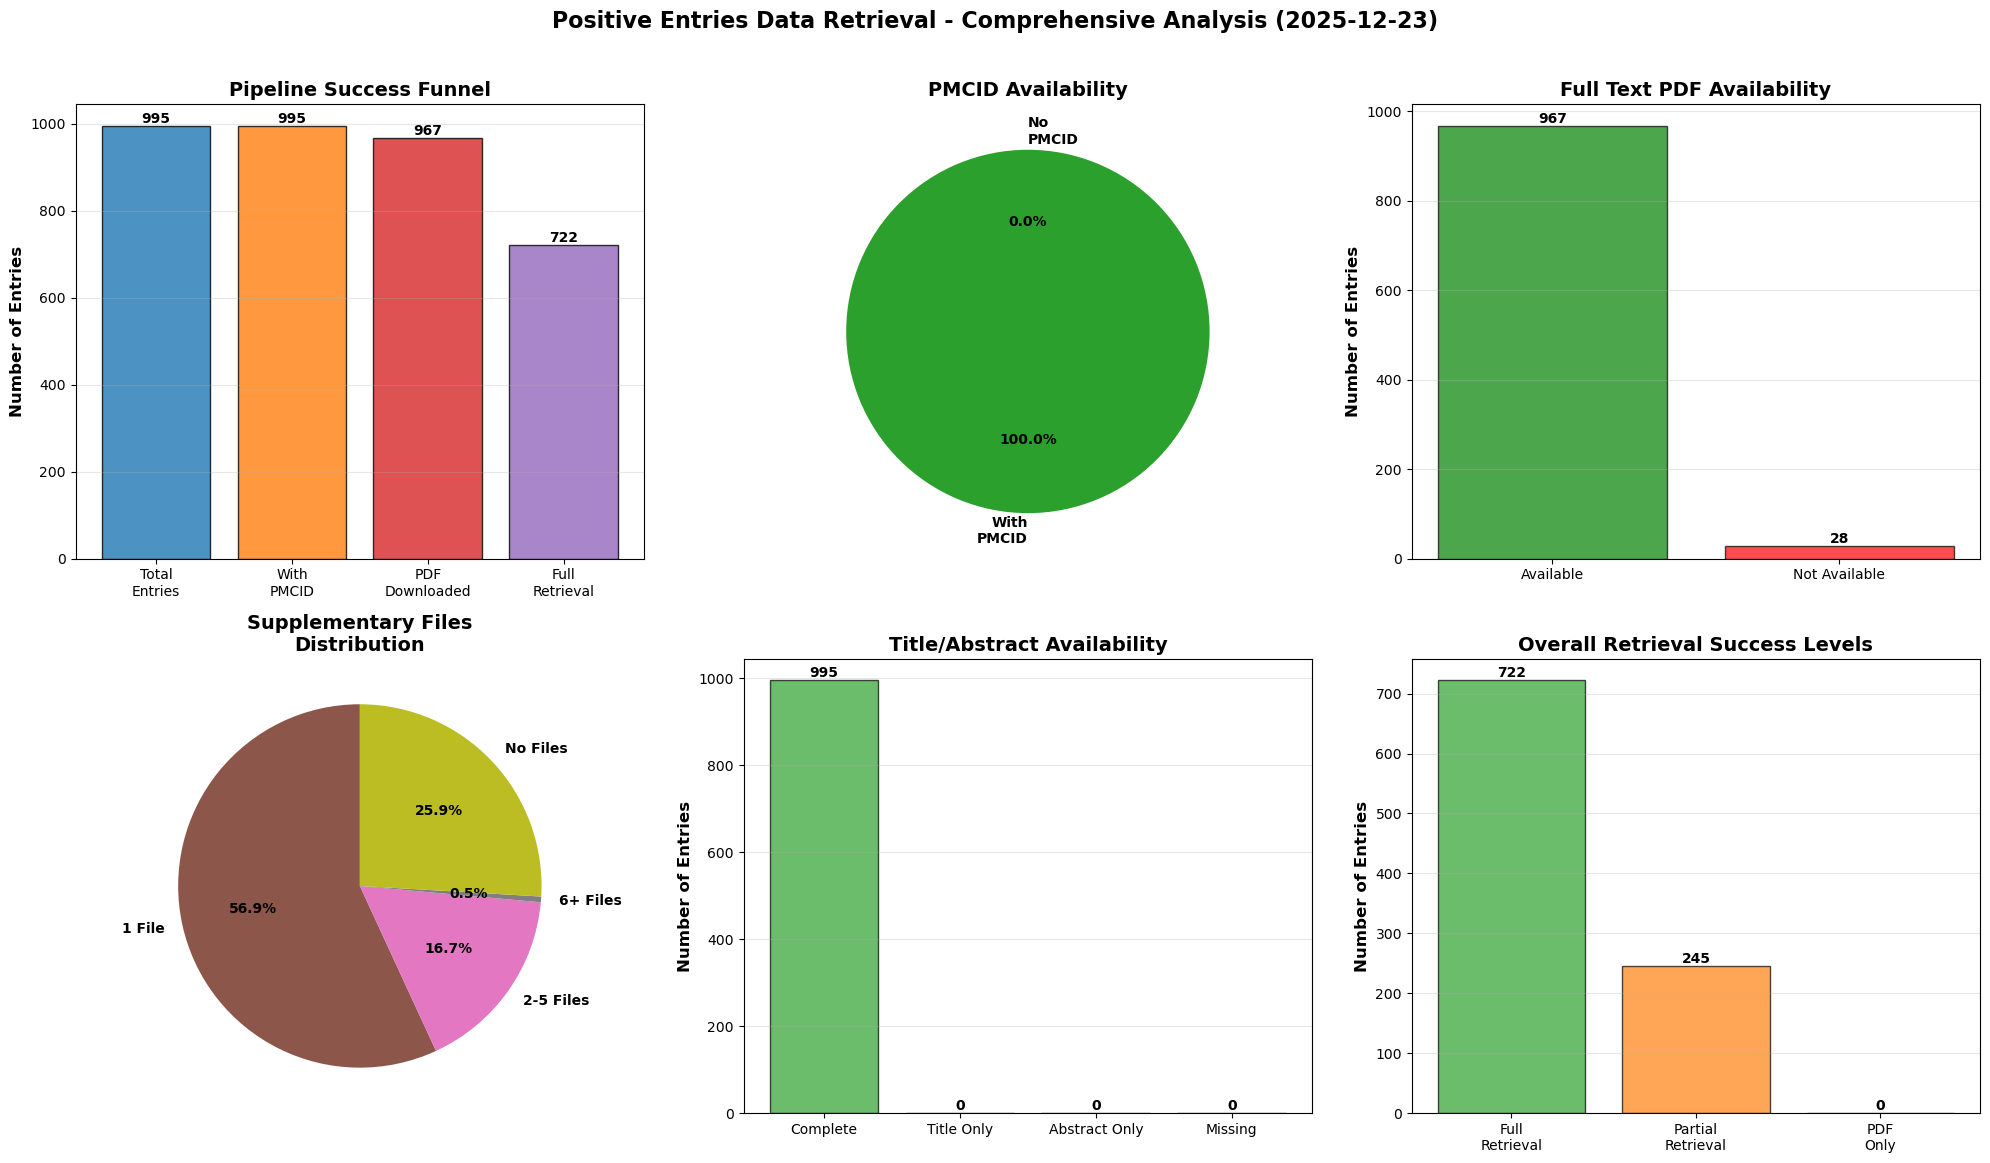


POSITIVE ENTRIES DATA RETRIEVAL - FINAL SUMMARY
Total entries: 995
PDF retrieval success: 97.2%
Supplementary files retrieved: 737 entries (1030 files)
Title/Abstract availability: 100.0%

Full data retrieval: 722 entries (72.6%)

All metadata files saved to: Positive_PMC_TSV_Files/
  - Positive_PMC_TSV_Files/Positive_Metadata_Complete.tsv
  - Positive_PMC_TSV_Files/Positive_Metadata_Summary.txt
  - Positive_PMC_TSV_Files/Positive_Metadata_Complete_Analysis.png


In [8]:
# 6. Create comprehensive metadata analysis and visualizations
# Adapted for Positive Entries

print("="*60)
print("GENERATING COMPREHENSIVE METADATA REPORT")
print("="*60)

# Read in the final TSV file
df = pd.read_csv(output_tsv_file_name, sep='\t')

# ============================================================================
# SECTION 1: REGISTRY RETRIEVAL METRICS
# ============================================================================
print("\n1. Analyzing Registry retrieval...")

total_entries = len(df)
entries_with_doi = df['publication_doi'].notna().sum()
entries_without_doi = total_entries - entries_with_doi

print(f"  Total Entries: {total_entries}")
print(f"  Entries with DOI: {entries_with_doi}")
print(f"  Entries without DOI: {entries_without_doi}")

# ============================================================================
# SECTION 2: DOI-TO-PMCID MAPPING METRICS
# ============================================================================
print("\n2. Analyzing PMCID availability...")

entries_with_pmcid = df['mapped_pmcid'].notna().sum()
entries_with_pmid = df['mapped_pmid'].notna().sum()
entries_with_pmid_only = (df['mapped_pmid'].notna() & df['mapped_pmcid'].isna()).sum()

# Calculate mapping success rate (In this context, we started with PMCIDs, so it should be 100% or close)
mapping_success = entries_with_pmcid
mapping_attempted = total_entries # We assume all entries were candidates
mapping_success_rate = (mapping_success / mapping_attempted * 100) if mapping_attempted > 0 else 0

print(f"  Entries processed: {mapping_attempted}")
print(f"  Entries with PMCID: {entries_with_pmcid} ({mapping_success_rate:.1f}%)")
print(f"  Entries with PMID only: {entries_with_pmid_only}")

# ============================================================================
# SECTION 3: FULL TEXT PDF RETRIEVAL METRICS
# ============================================================================
print("\n3. Analyzing full text PDF retrieval...")

pdf_available = df['pdf_downloadable'].value_counts().get('yes', 0)
pdf_not_available = df['pdf_downloadable'].value_counts().get('no', 0)
pdf_success_rate = (pdf_available / entries_with_pmcid * 100) if entries_with_pmcid > 0 else 0

print(f"  PDFs successfully downloaded: {pdf_available} ({pdf_success_rate:.1f}% of PMCIDs)")
print(f"  PDFs not available: {pdf_not_available}")

# ============================================================================
# SECTION 4: SUPPLEMENTARY FILES METRICS
# ============================================================================
print("\n4. Analyzing supplementary files retrieval...")

entries_with_supp = (df['supplementary_file_count'] > 0).sum()
entries_without_supp = total_entries - entries_with_supp
total_supp_files = int(df['supplementary_file_count'].sum())

# Breakdown by number of supplementary files
supp_file_distribution = df[df['supplementary_file_count'] > 0]['supplementary_file_count'].value_counts().sort_index()
entries_with_1_file = supp_file_distribution.get(1, 0)
entries_with_2_5_files = supp_file_distribution[(supp_file_distribution.index >= 2) & (supp_file_distribution.index <= 5)].sum()
entries_with_6plus_files = supp_file_distribution[supp_file_distribution.index > 5].sum()

avg_supp_per_entry = (total_supp_files / entries_with_supp) if entries_with_supp > 0 else 0
supp_success_rate = (entries_with_supp / entries_with_pmcid * 100) if entries_with_pmcid > 0 else 0

print(f"  Entries with supplementary files: {entries_with_supp} ({supp_success_rate:.1f}% of PMCIDs)")
print(f"  Total supplementary files downloaded: {total_supp_files}")
print(f"  Average files per entry (with supp): {avg_supp_per_entry:.2f}")
print(f"  Entries with 1 file: {entries_with_1_file}")
print(f"  Entries with 2-5 files: {entries_with_2_5_files}")
print(f"  Entries with 6+ files: {entries_with_6plus_files}")

# ============================================================================
# SECTION 5: TITLE/ABSTRACT ENRICHMENT METRICS
# ============================================================================
print("\n5. Analyzing title/abstract availability...")

title_abstract_available = (df['article_title'].notna() & df['article_abstract'].notna()).sum()
title_only = (df['article_title'].notna() & df['article_abstract'].isna()).sum()
abstract_only = (df['article_title'].isna() & df['article_abstract'].notna()).sum()
title_abstract_missing = total_entries - title_abstract_available - title_only - abstract_only

enrichment_success_rate = (title_abstract_available / entries_with_pmcid * 100) if entries_with_pmcid > 0 else 0

print(f"  Complete title & abstract: {title_abstract_available} ({enrichment_success_rate:.1f}% of PMCIDs)")
print(f"  Title only: {title_only}")
print(f"  Abstract only: {abstract_only}")
print(f"  Neither available: {title_abstract_missing}")

# ============================================================================
# SECTION 6: OVERALL SUCCESS METRICS
# ============================================================================
print("\n6. Calculating overall pipeline success...")

# Full data retrieval success (PDF + Supp + Title/Abstract)
full_success = ((df['pdf_downloadable'] == 'yes') & 
                (df['supplementary_file_count'] > 0) & 
                (df['article_title'].notna()) & 
                (df['article_abstract'].notna())).sum()

# Partial success (PDF + Title/Abstract, no supp required)
partial_success = ((df['pdf_downloadable'] == 'yes') & 
                   (df['article_title'].notna()) & 
                   (df['article_abstract'].notna())).sum()

# At least PDF
pdf_only_success = (df['pdf_downloadable'] == 'yes').sum()

print(f"  Full data retrieval (PDF + Supp + Title/Abstract): {full_success} ({full_success/total_entries*100:.1f}%)")
print(f"  PDF + Title/Abstract (no supp required): {partial_success} ({partial_success/total_entries*100:.1f}%)")
print(f"  At least PDF available: {pdf_only_success} ({pdf_only_success/total_entries*100:.1f}%)")

# ============================================================================
# SECTION 7: CREATE COMPREHENSIVE METADATA TSV
# ============================================================================
print("\n7. Creating metadata TSV file...")

metadata = pd.DataFrame({
    'Metric': [
        # Registry
        'Total Entries',
        'Entries with DOI',
        'Entries without DOI',
        '',
        # PMCID Availability
        'Entries with PMCID',
        'Entries with PMID Only',
        '',
        # PDF Retrieval
        'PDF - Successfully Downloaded',
        'PDF - Not Available',
        'PDF - Success Rate (% of PMCIDs)',
        '',
        # Supplementary Files
        'Supplementary - Entries with Files',
        'Supplementary - Total Files Count',
        'Supplementary - Avg Files per Entry',
        'Supplementary - Success Rate (% of PMCIDs)',
        'Supplementary - Entries with 1 File',
        'Supplementary - Entries with 2-5 Files',
        'Supplementary - Entries with 6+ Files',
        '',
        # Title/Abstract
        'Title/Abstract - Complete',
        'Title/Abstract - Title Only',
        'Title/Abstract - Abstract Only',
        'Title/Abstract - Neither',
        'Title/Abstract - Success Rate (% of PMCIDs)',
        '',
        # Overall Success
        'Overall - Full Retrieval (PDF+Supp+Title/Abstract)',
        'Overall - Partial Retrieval (PDF+Title/Abstract)',
        'Overall - Minimum Retrieval (PDF Only)'
    ],
    'Count': [
        # Registry
        total_entries,
        entries_with_doi,
        entries_without_doi,
        '',
        # PMCID Availability
        entries_with_pmcid,
        entries_with_pmid_only,
        '',
        # PDF Retrieval
        pdf_available,
        pdf_not_available,
        f"{pdf_success_rate:.1f}",
        '',
        # Supplementary Files
        entries_with_supp,
        total_supp_files,
        f"{avg_supp_per_entry:.2f}",
        f"{supp_success_rate:.1f}",
        entries_with_1_file,
        entries_with_2_5_files,
        entries_with_6plus_files,
        '',
        # Title/Abstract
        title_abstract_available,
        title_only,
        abstract_only,
        title_abstract_missing,
        f"{enrichment_success_rate:.1f}",
        '',
        # Overall Success
        full_success,
        partial_success,
        pdf_only_success
    ]
})

metadata_tsv_path = os.path.join(tsv_output_folder, 'Positive_Metadata_Complete.tsv')
metadata.to_csv(metadata_tsv_path, sep='\t', index=False)
print(f"  ✓ Metadata TSV saved to '{metadata_tsv_path}'")

# ============================================================================
# SECTION 8: CREATE DETAILED TEXT SUMMARY
# ============================================================================
print("\n8. Creating detailed text summary...")

summary_text_path = os.path.join(tsv_output_folder, 'Positive_Metadata_Summary.txt')
with open(summary_text_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("POSITIVE ENTRIES DATA RETRIEVAL - COMPREHENSIVE SUMMARY\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*80 + "\n\n")
    
    f.write("1. REGISTRY RETRIEVAL\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total entries processed: {total_entries}\n")
    f.write(f"Entries with DOI: {entries_with_doi} ({entries_with_doi/total_entries*100:.1f}%)\n")
    
    f.write("2. PMCID AVAILABILITY\n")
    f.write("-" * 80 + "\n")
    f.write(f"Entries with PMCID: {entries_with_pmcid} ({mapping_success_rate:.1f}%)\n")
    
    f.write("3. FULL TEXT PDF RETRIEVAL\n")
    f.write("-" * 80 + "\n")
    f.write(f"PDFs successfully downloaded: {pdf_available}\n")
    f.write(f"Success rate: {pdf_success_rate:.1f}% of entries with PMCIDs\n")
    
    f.write("4. SUPPLEMENTARY FILES RETRIEVAL\n")
    f.write("-" * 80 + "\n")
    f.write(f"Entries with supplementary files: {entries_with_supp} ({supp_success_rate:.1f}% of PMCIDs)\n")
    f.write(f"Total supplementary files downloaded: {total_supp_files}\n")
    
    f.write("5. TITLE & ABSTRACT AVAILABILITY\n")
    f.write("-" * 80 + "\n")
    f.write(f"Complete title & abstract: {title_abstract_available} ({enrichment_success_rate:.1f}% of PMCIDs)\n")
    
    f.write("6. OVERALL PIPELINE SUCCESS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Full data retrieval (PDF + Supp + Title/Abstract): {full_success} ({full_success/total_entries*100:.1f}%)\n")
    f.write(f"Partial retrieval (PDF + Title/Abstract): {partial_success} ({partial_success/total_entries*100:.1f}%)")
    f.write(f"Minimum retrieval (PDF only): {pdf_only_success} ({pdf_only_success/total_entries*100:.1f}%)\n\n")
    
    f.write("7. DATA LOCATIONS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Main TSV file: {output_tsv_file_name}\n")
    f.write(f"Full text PDFs: {pdf_output_folder}/\n")
    f.write(f"Supplementary files: {supp_output_folder}/\n")
    f.write(f"Metadata files: {tsv_output_folder}/\n\n")
    
    f.write("="*80 + "\n")
    f.write("END OF SUMMARY\n")
    f.write("="*80 + "\n")

print(f"  ✓ Summary text saved to '{summary_text_path}'")

# ============================================================================
# SECTION 9: CREATE COMPREHENSIVE VISUALIZATIONS
# ============================================================================
print("\n9. Creating comprehensive visualizations...")

# Create a larger figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# Plot 1: Overall Pipeline Success
ax1 = plt.subplot(2, 3, 1)
pipeline_stages = ['Total\nEntries', 'With\nPMCID', 'PDF\nDownloaded', 'Full\nRetrieval']
pipeline_counts = [total_entries, entries_with_pmcid, pdf_available, full_success]
colors_pipeline = ['#1f77b4', '#ff7f0e', '#d62728', '#9467bd']
bars1 = ax1.bar(pipeline_stages, pipeline_counts, color=colors_pipeline, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax1.set_title('Pipeline Success Funnel', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Plot 2: PMCID Availability (Simplified)
ax2 = plt.subplot(2, 3, 2)
mapping_labels = ['With\nPMCID', 'No\nPMCID']
mapping_values = [entries_with_pmcid, total_entries - entries_with_pmcid]
colors_mapping = ['#2ca02c', '#d62728']
wedges2, texts2, autotexts2 = ax2.pie(mapping_values, labels=mapping_labels, autopct='%1.1f%%',
                                        colors=colors_mapping, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('PMCID Availability', fontsize=14, fontweight='bold')

# Plot 3: PDF Availability
ax3 = plt.subplot(2, 3, 3)
pdf_labels = ['Available', 'Not Available']
pdf_values = [pdf_available, pdf_not_available]
colors_pdf = ['green', 'red']
bars3 = ax3.bar(pdf_labels, pdf_values, color=colors_pdf, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax3.set_title('Full Text PDF Availability', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Plot 4: Supplementary Files Distribution
ax4 = plt.subplot(2, 3, 4)
supp_labels = ['1 File', '2-5 Files', '6+ Files', 'No Files']
supp_values = [entries_with_1_file, entries_with_2_5_files, 
               entries_with_6plus_files, entries_without_supp]
colors_supp = ['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
wedges4, texts4, autotexts4 = ax4.pie(supp_values, labels=supp_labels, autopct='%1.1f%%',
                                        colors=colors_supp, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Supplementary Files\nDistribution', fontsize=14, fontweight='bold')

# Plot 5: Title/Abstract Enrichment
ax5 = plt.subplot(2, 3, 5)
enrichment_labels = ['Complete', 'Title Only', 'Abstract Only', 'Missing']
enrichment_values = [title_abstract_available, title_only, abstract_only, title_abstract_missing]
colors_enrich = ['#2ca02c', '#ff7f0e', '#1f77b4', '#d62728']
bars5 = ax5.bar(enrichment_labels, enrichment_values, color=colors_enrich, alpha=0.7, edgecolor='black')
ax5.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax5.set_title('Title/Abstract Availability', fontsize=14, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for bar in bars5:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Plot 6: Overall Success Levels
ax6 = plt.subplot(2, 3, 6)
success_labels = ['Full\nRetrieval', 'Partial\nRetrieval', 'PDF\nOnly']
success_values = [full_success, partial_success - full_success, pdf_only_success - partial_success]
colors_success = ['#2ca02c', '#ff7f0e', '#d62728']
bars6 = ax6.bar(success_labels, success_values, color=colors_success, alpha=0.7, edgecolor='black')
ax6.set_ylabel('Number of Entries', fontsize=12, fontweight='bold')
ax6.set_title('Overall Retrieval Success Levels', fontsize=14, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
for bar in bars6:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Add overall title
current_date = datetime.now().strftime('%Y-%m-%d')
fig.suptitle(f'Positive Entries Data Retrieval - Comprehensive Analysis ({current_date})', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Save the comprehensive plot
plot_image_path = os.path.join(tsv_output_folder, 'Positive_Metadata_Complete_Analysis.png')
plt.savefig(plot_image_path, dpi=300, bbox_inches='tight')
print(f"  ✓ Comprehensive charts saved to '{plot_image_path}'")

plt.show()

# ============================================================================
# FINAL SUMMARY PRINTOUT
# ============================================================================
print("\n" + "="*60)
print("POSITIVE ENTRIES DATA RETRIEVAL - FINAL SUMMARY")
print("="*60)
print(f"Total entries: {total_entries}")
print(f"PDF retrieval success: {pdf_success_rate:.1f}%")
print(f"Supplementary files retrieved: {entries_with_supp} entries ({total_supp_files} files)")
print(f"Title/Abstract availability: {enrichment_success_rate:.1f}%")
print(f"\nFull data retrieval: {full_success} entries ({full_success/total_entries*100:.1f}%)")
print("="*60)
print(f"\nAll metadata files saved to: {tsv_output_folder}/")
print(f"  - {metadata_tsv_path}")
print(f"  - {summary_text_path}")
print(f"  - {plot_image_path}")
print("="*60)